In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import pandas as pd
import pyodbc
import numpy as np

import pathlib
from matplotlib import pyplot as plt
from scipy.io import loadmat
import random
import numpy
from time import time

from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers,models,initializers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from keras.wrappers.scikit_learn import KerasClassifier

import operator
from operator import itemgetter
from PIL import Image

In [ ]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical

# Data Loading

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
dataset = dataset.batch(128)

In [ ]:
test_ds = test_ds.batch(128)

In [ ]:
num_classes=10

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 256

We try to expand the Architecture V2 by adding another convolutional layer with 256 filters.

In [ ]:
inputs = keras.Input((None, None ,3)) # righe, colonne, canali (nel nostro caso 3 x immagini RGB)

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same")(x)  # 32 filtri di dimensione 3x3; Il padding aggiungere una "cornice" all'immagine in modo che l'immagine venga analizzata per intero durante convoluzione
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x) # layer che introduce non linearità: il passaggio  tra input e output non avviene per mezzo di una semplice combinazione lineare ma crea un livello di complessità e astrazione maggiore
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #finestre 3x3 e stride pari a 3; ogni 3x3 valori di input vengono sostituiti con il valore max, successivamente si sposta la finestra di 3 pixel a destra.
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv2D(256, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x) # al posto di una finestra 3x3, utilizza una finestra grande quanto  l'intera attivazione del layer precedente
x = keras.layers.Flatten()(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x) #fully connected (in keras dense):
                                                                   # ha un'attivazione softmax, quest'ultima prende i due numeri  restituiti dal layer dense e li da in input ad una funzione che ha lo scopo di produrre una
                                                                   # pseudo distribuzione di probabilità (si assicura che la somma dei due valori sia pari a 1).

net = keras.Model(inputs, outputs)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history = net.fit(dataset,
          epochs=50,
          validation_data=test_ds,
         callbacks = [callback]
                  );

Epoch 1/50
391/391 [==============================] - 10s 8ms/step - loss: 1.8362 - accuracy: 0.3260 - val_loss: 1.6680 - val_accuracy: 0.3946
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 1.5725 - accuracy: 0.4237 - val_loss: 1.8355 - val_accuracy: 0.3662
Epoch 3/50
391/391 [==============================] - 3s 7ms/step - loss: 1.4496 - accuracy: 0.4684 - val_loss: 1.7194 - val_accuracy: 0.3822
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 1.3698 - accuracy: 0.5021 - val_loss: 1.4512 - val_accuracy: 0.4974
Epoch 5/50
391/391 [==============================] - 3s 7ms/step - loss: 1.3089 - accuracy: 0.5275 - val_loss: 1.5998 - val_accuracy: 0.4433
Epoch 6/50
391/391 [==============================] - 3s 7ms/step - loss: 1.2724 - accuracy: 0.5402 - val_loss: 1.2769 - val_accuracy: 0.5301
Epoch 7/50
391/391 [==============================] - 3s 7ms/step - loss: 1.2396 - accuracy: 0.5546 - val_loss: 1.1770 - val_accuracy: 0.5714
Epoch

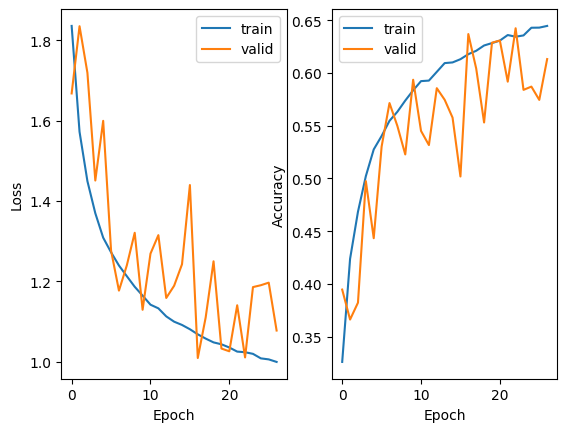

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

The graph shows how the result can be rejcted, as the accuracy has worsened and the overfitting is higher.

# 5x5 Kernel

We modify the V3 model by using a kernel size of 5x5 instead of 3x3

In [ ]:
def block(inputs, filters):
    x = keras.layers.Conv2D(filters, 5, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

inputs = keras.Input((32,32,3))

x = inputs

for i in range(4):
    x = block(x, 32)

x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

for i in range(4):
    x = block(x, 64)

x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

x = block(x,128)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs, outputs)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
            metrics=['accuracy'])

In [ ]:
history = net.fit(dataset,
          epochs=50,
          validation_data=test_ds,
          callbacks = [callback]
                  );

Epoch 1/50
391/391 [==============================] - 18s 42ms/step - loss: 1.5716 - accuracy: 0.4168 - val_loss: 1.2951 - val_accuracy: 0.5400
Epoch 2/50
391/391 [==============================] - 16s 42ms/step - loss: 1.1016 - accuracy: 0.6029 - val_loss: 1.0538 - val_accuracy: 0.6239
Epoch 3/50
391/391 [==============================] - 16s 42ms/step - loss: 0.9122 - accuracy: 0.6731 - val_loss: 1.0488 - val_accuracy: 0.6433
Epoch 4/50
391/391 [==============================] - 16s 42ms/step - loss: 0.7937 - accuracy: 0.7203 - val_loss: 1.0708 - val_accuracy: 0.6369
Epoch 5/50
391/391 [==============================] - 17s 42ms/step - loss: 0.7156 - accuracy: 0.7504 - val_loss: 1.0033 - val_accuracy: 0.6720
Epoch 6/50
391/391 [==============================] - 17s 43ms/step - loss: 0.6561 - accuracy: 0.7721 - val_loss: 0.9833 - val_accuracy: 0.6764
Epoch 7/50
391/391 [==============================] - 17s 42ms/step - loss: 0.6094 - accuracy: 0.7882 - val_loss: 1.1390 - val_accuracy:

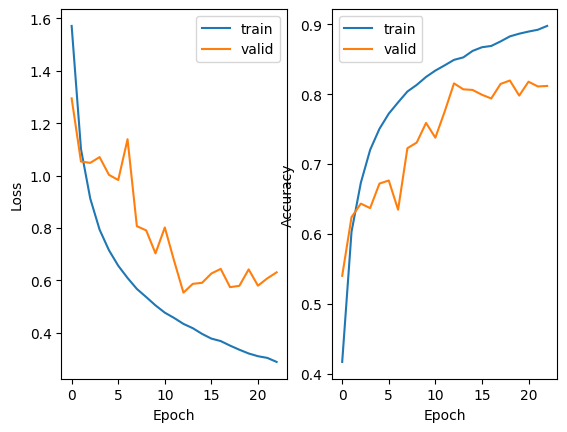

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In this case the overfitting is clearly increased.

# Data Augmentation

We try to use data augmentation techniques in order to reduce the overfitting in the model V3.

In [ ]:
def augment(image, label):
    # Randomly flip image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip image vertically
    image = tf.image.random_flip_up_down(image)
    # Randomly rotate image by 0, 90, 180, or 270 degrees
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)


    label = label
    return image, label


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# We apply the random augmentation on the train dataset and then we repeat the dataset
# Given the fact that the augmentation are created randomly, every repetition of the dataset is different
def augment_ds(train):
    ds = train.map(lambda  x, y: augment(x,y))

    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_augmented = augment_ds(dataset)

In [ ]:
def block(inputs, filters):
    x = keras.layers.Conv2D(filters, 3, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

inputs = keras.Input((32,32,3))

x = inputs

for i in range(4):
    x = block(x, 32)

x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

for i in range(4):
    x = block(x, 64)

x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

x = block(x,128)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs, outputs)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history = net.fit(train_augmented,
          epochs=50,
          steps_per_epoch=391,
          validation_data=test_ds,
          callbacks = [callback]
                  );

Epoch 1/50
391/391 [==============================] - 10s 24ms/step - loss: 1.9165 - accuracy: 0.3039 - val_loss: 1.8679 - val_accuracy: 0.3130
Epoch 2/50
391/391 [==============================] - 9s 24ms/step - loss: 1.5825 - accuracy: 0.4214 - val_loss: 1.8346 - val_accuracy: 0.3489
Epoch 3/50
391/391 [==============================] - 9s 24ms/step - loss: 1.4469 - accuracy: 0.4762 - val_loss: 1.3743 - val_accuracy: 0.5087
Epoch 4/50
391/391 [==============================] - 10s 24ms/step - loss: 1.3637 - accuracy: 0.5068 - val_loss: 1.3806 - val_accuracy: 0.5039
Epoch 5/50
391/391 [==============================] - 10s 24ms/step - loss: 1.3002 - accuracy: 0.5332 - val_loss: 1.4027 - val_accuracy: 0.5008
Epoch 6/50
391/391 [==============================] - 10s 24ms/step - loss: 1.2413 - accuracy: 0.5549 - val_loss: 1.2624 - val_accuracy: 0.5390
Epoch 7/50
391/391 [==============================] - 10s 24ms/step - loss: 1.1948 - accuracy: 0.5674 - val_loss: 1.4065 - val_accuracy: 0

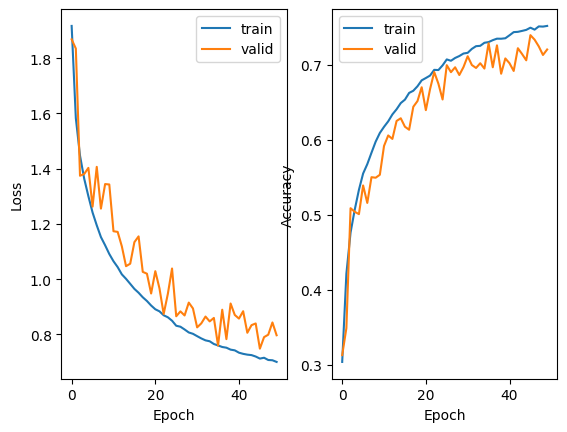

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

We have successfully reduced the overfitting, but the validation accuracy is higly decreased.